# State Farm Distracted Driver Detection

In [1]:
%matplotlib inline

**Action Plan**
1. Create Validation and Sample sets
2. Create Model
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## 1. Create Validation and Sample Sets

In [2]:
import os
LESSON_HOME_DIR = os.getcwd()
DATA_HOME_DIR = LESSON_HOME_DIR + '/data/state-farm-distracted-driver-detection'

### 1.1. Create Directories

In [3]:
%mkdir -p $DATA_HOME_DIR

%cd $DATA_HOME_DIR

%mkdir results
%mkdir -p sample/results
%mkdir -p sample/test
%mkdir -p sample/train
%mkdir -p sample/valid
%mkdir test
%mkdir valid

/home/ubuntu/practical-deep-learning-for-coders/competitions/state-farm-distracted-driver-detection/data/state-farm-distracted-driver-detection


### 1.2. Download Kaggle Data

In [4]:
%cd $LESSON_HOME_DIR

/home/ubuntu/practical-deep-learning-for-coders/competitions/state-farm-distracted-driver-detection


In [9]:
!kg download

Starting new HTTPS connection (1): www.kaggle.com
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/sample_submission.csv.zip
Starting new HTTPS connection (1): kaggle2.blob.core.windows.net
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/imgs.zip
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/driver_imgs_list.csv.zip
Resetting dropped connection: www.kaggle.com


### 1.3. Extract Data

In [7]:
%cd $LESSON_HOME_DIR

/home/ubuntu/practical-deep-learning-for-coders/competitions/state-farm-distracted-driver-detection


In [6]:
!unzip imgs.zip -d data/state-farm-distracted-driver-detection/ >nul 2>&1

In [5]:
!unzip driver_imgs_list.csv.zip -d data/state-farm-distracted-driver-detection/ >nul 2>&1

### 1.4. Create Validation Set

In [8]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/practical-deep-learning-for-coders/competitions/state-farm-distracted-driver-detection/data/state-farm-distracted-driver-detection/train


In [10]:
%mkdir -p $DATA_HOME_DIR/valid/c0
%mkdir -p $DATA_HOME_DIR/valid/c1
%mkdir -p $DATA_HOME_DIR/valid/c2
%mkdir -p $DATA_HOME_DIR/valid/c3
%mkdir -p $DATA_HOME_DIR/valid/c4
%mkdir -p $DATA_HOME_DIR/valid/c5
%mkdir -p $DATA_HOME_DIR/valid/c6
%mkdir -p $DATA_HOME_DIR/valid/c7
%mkdir -p $DATA_HOME_DIR/valid/c8
%mkdir -p $DATA_HOME_DIR/valid/c9

In [16]:
from glob import glob
import numpy as np
from shutil import copyfile

for i in range(10):
    images = glob("c%d/*.jpg" % i)
    shuffle = np.random.permutation(images)
    for j in range(50):
        copyfile(shuffle[j], DATA_HOME_DIR + '/valid/' + shuffle[j])

### Rearrange Test Set

In [ ]:
%cd $DATA_HOME_DIR/test
%mkdir unknown
%mv *.jpg unknown/

## 2. Create Model

Import dependencies

In [3]:
import numpy as np
from numpy.random import random
from numpy.random import permutation

np.set_printoptions(precision=4, linewidth=100)

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.preprocessing import image

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [4]:
class VGG16:
    def __init__(self):
        # When the VGG model was trained in 2014, the creators subtracted the
        # average of each of the three (R,G,B) channels first, so that the data
        # for each channel had a mean of zero.
        # Furthermore, their software that expected the channels to be in B,G,R order,
        # whereas Python by default uses R,G,B. We need to preprocess our data to
        # make these two changes, so that it is compatible with the VGG model:
        def vgg_preprocess(x):
            vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
            x = x - vgg_mean
            # reverse axis bgr->rgb
            return x[:, ::-1]

        self.model = Sequential()
        self.model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224)))
        
        self._add_convolutional_block(2, 64)
        self._add_convolutional_block(2, 128)
        self._add_convolutional_block(3, 256)
        self._add_convolutional_block(3, 512)
        self._add_convolutional_block(3, 512)

        self.model.add(Flatten())

        self._add_fully_connected_block()
        self._add_fully_connected_block()

        self.model.add(Dense(1000, activation='softmax'))
    
    def _add_convolutional_block(self, layers, filters):
        for i in range(layers):
            self.model.add(ZeroPadding2D((1,1)))
            self.model.add(Convolution2D(filters, 3, 3, activation='relu'))
        self.model.add(MaxPooling2D((2,2), strides=(2,2)))

    def _add_fully_connected_block(self):
        self.model.add(Dense(4096, activation='relu'))
        self.model.add(Dropout(0.5))
    
    def finetune(self, training_batches):
        self.model.pop()
        
        for layer in self.model.layers:
            layer.trainable = False
        
        self.model.add(Dense(training_batches.nb_class, activation='softmax'))
        self.model.compile(optimizer=RMSprop(lr=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        
    def fit(self, training_batches, validation_batches, nb_epoch=1):
        self.model.fit_generator(training_batches,
                            samples_per_epoch=training_batches.nb_sample,
                            nb_epoch=nb_epoch,
                            validation_data=validation_batches,
                            nb_val_samples=validation_batches.nb_sample)
        
    def test(self, test_batches):
        predictions = self.model.predict_generator(test_batches,
                                                   test_batches.nb_sample)
        return test_batches.filenames, predictions


def get_batches(directory,
                gen=image.ImageDataGenerator(),
                shuffle=True,
                batch_size=8,
                class_mode='categorical'):
    return gen.flow_from_directory(directory,
                                   target_size=(224, 224),
                                   shuffle=shuffle,
                                   batch_size=batch_size,
                                   class_mode=class_mode)

## 3. Finetuning and Training

In [6]:
RESULTS_PATH = DATA_HOME_DIR + '/results/'
TEST_PATH = DATA_HOME_DIR + '/test/'
TRAIN_PATH = DATA_HOME_DIR + '/train/'
VALID_PATH = DATA_HOME_DIR + '/valid/'

BATCH_SIZE = 64
EPOCHS = 10

In [7]:
PRE_TRAINED_WEIGHTS_FILE = 'vgg16.h5'
pre_trained_weights = get_file(PRE_TRAINED_WEIGHTS_FILE,
                               'http://www.platform.ai/models/' + PRE_TRAINED_WEIGHTS_FILE,
                               cache_subdir='models')

In [8]:
vgg = VGG16()

In [9]:
vgg.model.load_weights(pre_trained_weights)

In [10]:
training_batches = get_batches(TRAIN_PATH, batch_size=BATCH_SIZE)
validation_batches = get_batches(VALID_PATH, batch_size=BATCH_SIZE)
vgg.finetune(training_batches)

Found 22424 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [11]:
latest_weight_filename = None
for epoch in range(EPOCHS):
    print "Running epoch: %d" % (epoch + 1)
    vgg.fit(training_batches, validation_batches)
    latest_weight_filename = "state-farm-distracted-driver-detection-fit-%d.h5" % (epoch + 1)
    vgg.model.save_weights(RESULTS_PATH + latest_weight_filename)
    
print "Completed %d fit operations" % EPOCHS

Running epoch: 1
Epoch 1/1
22424/22424 [==============================] - 558s - loss: 2.0787 - acc: 0.4473 - val_loss: 0.8355 - val_acc: 0.6980
Running epoch: 2
Epoch 1/1
22424/22424 [==============================] - 553s - loss: 1.1829 - acc: 0.6423 - val_loss: 0.3896 - val_acc: 0.8860
Running epoch: 3
Epoch 1/1
22424/22424 [==============================] - 553s - loss: 1.0363 - acc: 0.6873 - val_loss: 0.3982 - val_acc: 0.8760
Running epoch: 4
Epoch 1/1
22424/22424 [==============================] - 553s - loss: 0.9870 - acc: 0.7062 - val_loss: 0.3550 - val_acc: 0.8920
Running epoch: 5
Epoch 1/1
22424/22424 [==============================] - 553s - loss: 0.9414 - acc: 0.7158 - val_loss: 0.3536 - val_acc: 0.8760
Running epoch: 6
Epoch 1/1
22424/22424 [==============================] - 557s - loss: 0.9259 - acc: 0.7291 - val_loss: 0.2016 - val_acc: 0.9500
Running epoch: 7
Epoch 1/1
22424/22424 [==============================] - 559s - loss: 0.9480 - acc: 0.7274 - val_loss: 0.4053 - v

## 4. Generate Predictions

In [14]:
vgg = VGG16()
vgg.model.load_weights(RESULTS_PATH + 'state-farm-distracted-driver-detection-fit-10.h5')

In [15]:
test_batches = get_batches(TEST_PATH,
                           shuffle=False,
                           batch_size=BATCH_SIZE,
                           class_mode=None)
filenames, predictions = vgg.test(test_batches)

Found 79726 images belonging to 1 classes.


In [16]:
import bcolz

f = bcolz.carray(filenames, rootdir=RESULTS_PATH + 'filenames.dat', mode='w')
f.flush()

p = bcolz.carray(predictions, rootdir=RESULTS_PATH + 'predictions.dat', mode='w')
p.flush()

## 5. Validate Predictions

In [9]:
vgg = VGG16()
vgg.model.load_weights(RESULTS_PATH + 'state-farm-distracted-driver-detection-fit-10.h5')

In [10]:
validation_batches = get_batches(VALID_PATH,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE,
                                 class_mode=None)
filenames, predictions = vgg.test(validation_batches)

Found 500 images belonging to 10 classes.


In [20]:
expected_labels = validation_batches.classes #0 or 1
actual_labels = np.argmax(predictions, axis=1)

In [17]:
from matplotlib import pyplot as plt
import itertools
from itertools import chain
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(VALID_PATH + filenames[i]) for i in idx], titles=titles)
    
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none')    

Found 453 correct labels


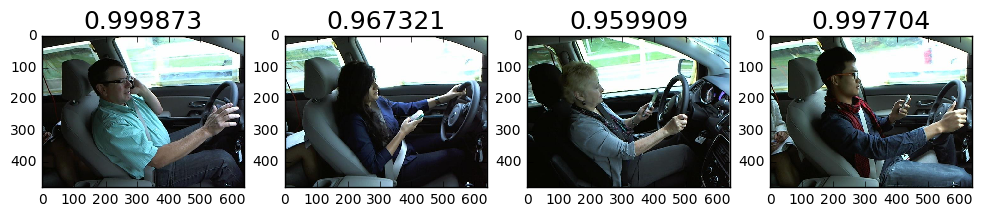

In [43]:
#1. Correct labels
correct = np.where(actual_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)

idx = permutation(correct)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 47 incorrect labels


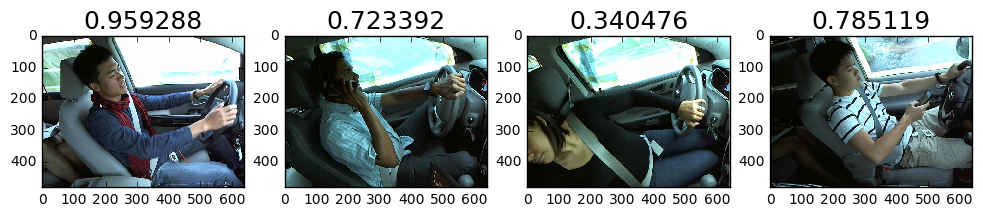

In [41]:
#2. Incorrect labels
incorrect = np.where(actual_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)

idx = permutation(incorrect)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 49 confident correct normal driving (c0) labels


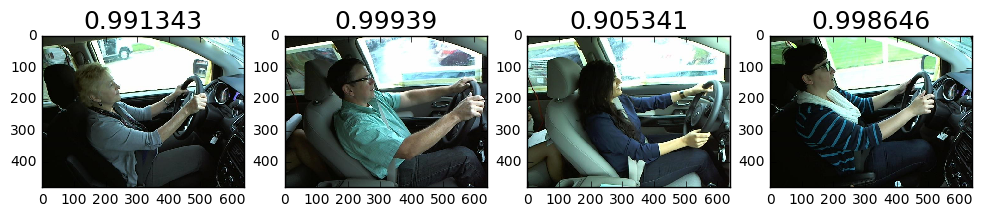

In [40]:
#3. The images we most confident were normal driving (c0), and are normal driving
normal_driving = np.where((actual_labels==0) & (actual_labels==expected_labels))[0]
print "Found %d confident correct normal driving (c0) labels" % len(normal_driving)

idx = permutation(normal_driving)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 46 confident correct texting - right (c1) labels


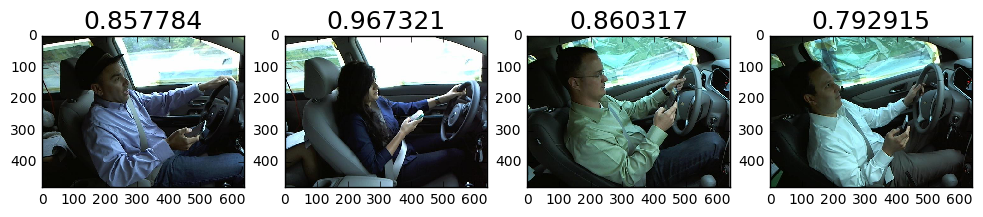

In [39]:
#4. The images we most confident were texting - right (c1), and are texting - right
texting_right = np.where((actual_labels==1) & (actual_labels==expected_labels))[0]
print "Found %d confident correct texting - right (c1) labels" % len(texting_right)

idx = permutation(texting_right)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 47 confident correct talking on the phone - right (c2) labels


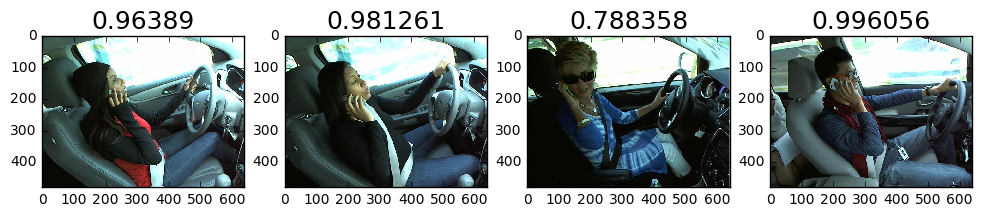

In [38]:
#5. The images we most confident were talking on the phone - right (c2), and are talking on the phone - right
talking_on_the_phone_right = np.where((actual_labels==2) & (actual_labels==expected_labels))[0]
print "Found %d confident correct talking on the phone - right (c2) labels" % len(talking_on_the_phone_right)

idx = permutation(talking_on_the_phone_right)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 49 confident correct texting - left (c3) labels


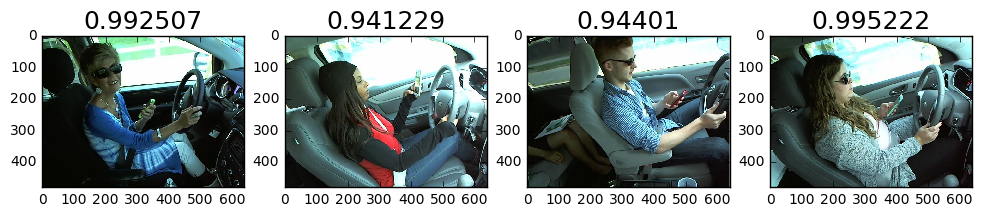

In [36]:
#6. The images we most confident were texting - left (c3), and are texting - left
texting_left = np.where((actual_labels==3) & (actual_labels==expected_labels))[0]
print "Found %d confident correct texting - left (c3) labels" % len(texting_left)

idx = permutation(texting_left)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 50 confident correct texting - left (c4) labels


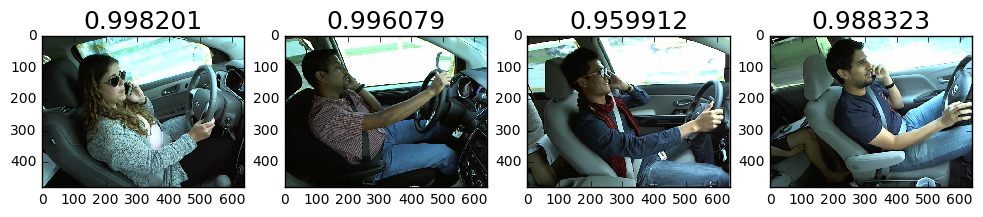

In [35]:
#7. The images we most confident were talking on the phone - left (c4), and are talking on the phone - left
talking_on_the_phone_left = np.where((actual_labels==4) & (actual_labels==expected_labels))[0]
print "Found %d confident correct texting - left (c4) labels" % len(talking_on_the_phone_left)

idx = permutation(talking_on_the_phone_left)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 50 confident correct operating the radio (c5) labels


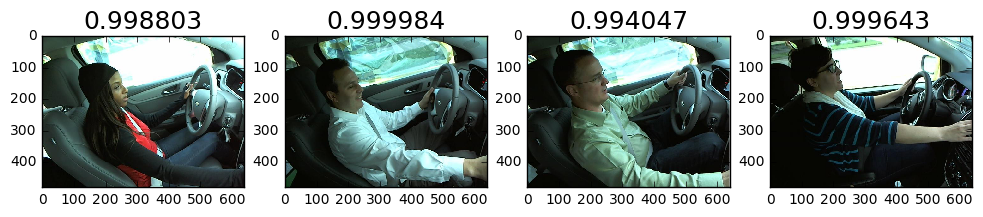

In [45]:
#8. The images we most confident were operating the radio (c5), and are operating the radio
operation_the_radio = np.where((actual_labels==5) & (actual_labels==expected_labels))[0]
print "Found %d confident correct operating the radio (c5) labels" % len(operation_the_radio)

idx = permutation(operation_the_radio)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 50 confident correct drinking (c6) labels


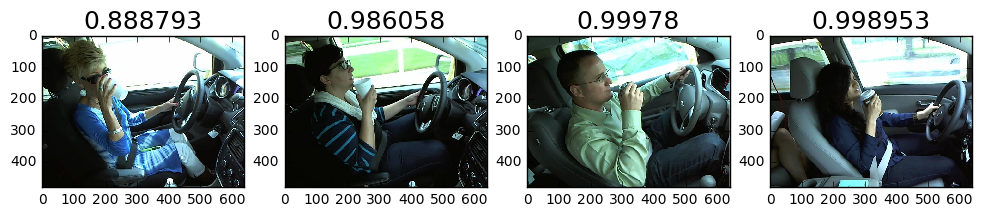

In [46]:
#9. The images we most confident were drinking (c6), and are drinking
drinking = np.where((actual_labels==6) & (actual_labels==expected_labels))[0]
print "Found %d confident correct drinking (c6) labels" % len(drinking)

idx = permutation(drinking)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 44 confident correct reaching behind (c7) labels


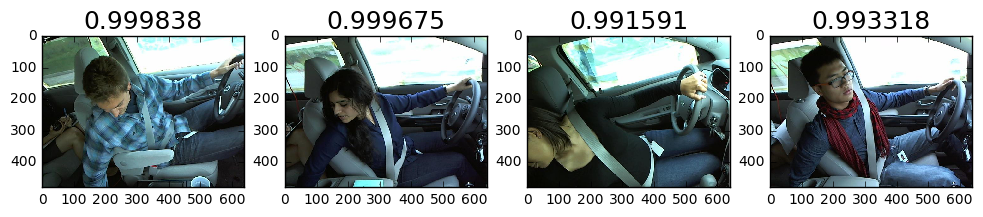

In [47]:
#10. The images we most confident were reaching behind (c7), and are reaching behind
reaching_behind = np.where((actual_labels==7) & (actual_labels==expected_labels))[0]
print "Found %d confident correct reaching behind (c7) labels" % len(reaching_behind)

idx = permutation(reaching_behind)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 28 confident correct hair and makeup (c8) labels


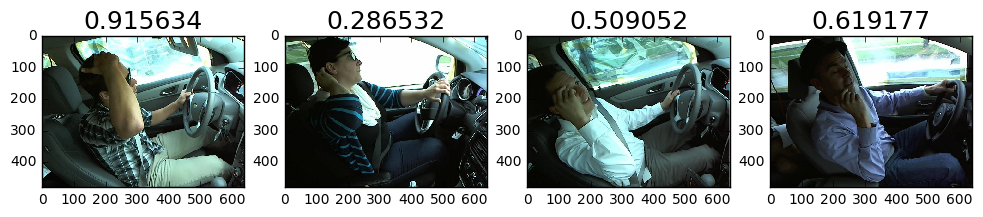

In [48]:
#11. The images we most confident were hair and makeup (c8), and are hair and makeup
hair_and_makeup = np.where((actual_labels==8) & (actual_labels==expected_labels))[0]
print "Found %d confident correct hair and makeup (c8) labels" % len(hair_and_makeup)

idx = permutation(hair_and_makeup)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

Found 40 confident correct talking to passenger (c9) labels


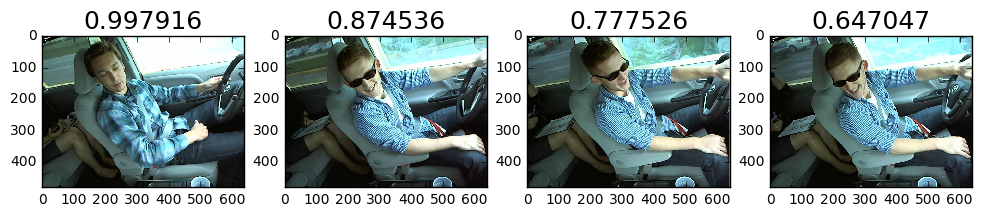

In [49]:
#12. The images we most confident were talking to passenger (c9), and are talking to passenger
talking_to_passenger = np.where((actual_labels==9) & (actual_labels==expected_labels))[0]
print "Found %d confident correct talking to passenger (c9) labels" % len(talking_to_passenger)

idx = permutation(talking_to_passenger)[:4]
plots_idx(idx, predictions[idx, np.argmax(predictions[idx], axis=1)])

In [50]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[49  0  0  0  0  0  1  0  0  0]
 [ 3 46  0  0  0  0  1  0  0  0]
 [ 1  1 47  0  0  0  1  0  0  0]
 [ 0  0  0 49  1  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 1  0  1  0  0  0  3 44  1  0]
 [ 4  0  2  0  3  0 12  0 28  1]
 [ 7  1  0  0  1  1  0  0  0 40]]


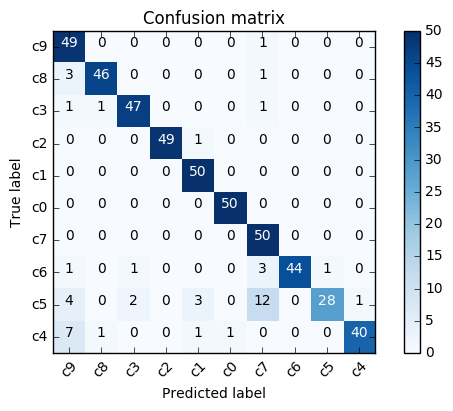

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, actual_labels)
plot_confusion_matrix(cm, validation_batches.class_indices)

## 7. Submit Predictions to Kaggle

In [54]:
import bcolz
predictions = bcolz.open(RESULTS_PATH + 'predictions.dat')[:]
filenames = bcolz.open(RESULTS_PATH + 'filenames.dat')[:]

In [80]:
ids = np.array([f.split('/')[1] for f in filenames])

In [85]:
import csv
submission = open('submission1.csv', 'wb')
submission_writer = csv.writer(submission, delimiter=',', quoting=csv.QUOTE_NONE)
submission_writer.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])

for row in zip(ids, predictions):
    img = row[0]
    prediction = row[1]
    c0 = prediction[0]
    c1 = prediction[1]
    c2 = prediction[2]
    c3 = prediction[3]
    c4 = prediction[4]
    c5 = prediction[5]
    c6 = prediction[6]
    c7 = prediction[7]
    c8 = prediction[8]
    c9 = prediction[9]

    submission_writer.writerow((img, c0, c1, c2, c3, c4, c5, c6, c7, c8, c9))
    
submission.close()

In [86]:
!kg submit submission1.csv

Starting new HTTPS connection (1): www.kaggle.com
'NoneType' object has no attribute 'find'
